Feedforward neural network
Mean Accuracy: 96.765%


Extreme learning machine
Mean Accuracy: 80.441%




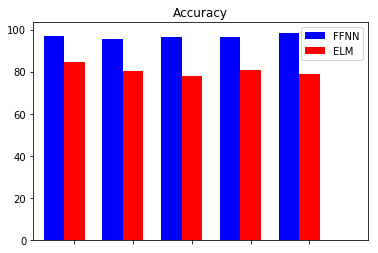

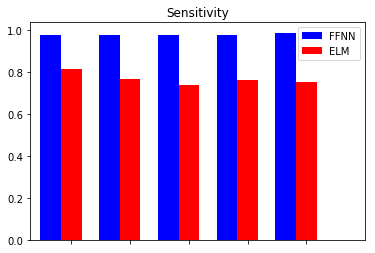

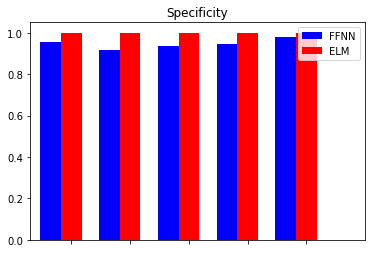

In [157]:
import numpy as np
from matplotlib import pyplot as plt
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp

def load_csv(filename):
    dataset = list()
    contains_missing_values = False
    
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            contains_missing_values = False 
            # Brisanje redova koji imaju ?. 
            for i in range(len(row)):
                if row[i] is '?':
                    contains_missing_values = True
                    break
            if contains_missing_values == False:
                row = row[1:len(row)]
                dataset.append(row)

    return dataset

def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column])

def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

def feedforward_initialize(n_inputs, n_hidden_nodes, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden_nodes)]
    output_layer = [{'weights':[random() for i in range(n_hidden_nodes + 1)]} for i in range(n_outputs)]
    network.append(hidden_layer)
    network.append(output_layer)
    return network

def train_test_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

def calculate_accuracy(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def calculate_accuracy_elm(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        predicted_transformed = 0
        if transfer(predicted[i]) > 0.5:
            predicted_transformed = 1
        else:
            predicted_transformed = 0
        if actual[i] == predicted_transformed:
            correct += 1
    return correct / float(len(actual)) * 100.0

def calculate_sensitivity(actual, predicted):
    correct = 0
    false_negative = 0
    for i in range(len(actual)):
        if actual[i] == 1 and predicted[i] == 1:
            correct += 1
        elif actual[i] == 0 and predicted[i] == 1:
            false_negative += 1
    return correct / (correct + false_negative)

def calculate_sensitivity_elm(actual, predicted):
    correct = 0
    false_negative = 0
    for i in range(len(actual)):
        predicted_transformed = 0
        if transfer(predicted[i]) > 0.5:
            predicted_transformed = 1
        else:
            predicted_transformed = 0
        if actual[i] == 1 and predicted_transformed == 1:
            correct += 1
        elif actual[i] == 0 and predicted_transformed == 1:
            false_negative += 1
    return correct / (correct + false_negative)

def calculate_specificity(actual, predicted):
    correct = 0
    false_positive = 0
    for i in range(len(actual)):
        if actual[i] == 0 and predicted[i] == 0:
            correct += 1
        elif actual[i] == 1 and predicted[i] == 0:
            false_positive += 1
    return correct / (correct + false_positive)

def calculate_specificity_elm(actual, predicted):
    correct = 0
    false_positive = 0
    for i in range(len(actual)):
        predicted_transformed = 0
        if transfer(predicted[i]) > 0.5:
            predicted_transformed = 1
        else:
            predicted_transformed = 0
        if actual[i] == 0 and predicted_transformed == 0:
            correct += 1
        elif actual[i] == 1 and predicted_transformed == 0:
            false_positive += 1
    return correct / (correct + false_positive)

def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * neuron['output'] * (1 - neuron['output'])

def update_weights(network, row, learn_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += learn_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += learn_rate * neuron['delta']

def train_network(network, train, learn_rate, n_epochs, n_outputs):
    for epoch in range(n_epochs):
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            backward_propagate_error(network, expected)
            update_weights(network, row, learn_rate)

def back_propagation(train, test, learn_rate, n_epochs, n_hidden_nodes):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = feedforward_initialize(n_inputs, n_hidden_nodes, n_outputs)
    train_network(network, train, learn_rate, n_epochs, n_outputs)
    
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

def feedforward_algorithm(dataset, n_folds, learn_rate, n_epochs, n_hidden_nodes):
    folds = train_test_split(dataset, n_folds)  
    scores = list()
    sensitivities = list()
    specificities = list()
    
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = back_propagation(train_set, test_set, learn_rate, n_epochs, n_hidden_nodes)
        actual = [row[-1] for row in fold]
        accuracy = calculate_accuracy(actual, predicted)
        sensitivity = calculate_sensitivity(actual, predicted)
        specificity = calculate_specificity(actual, predicted)
        
        scores.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
    return scores, sensitivities, specificities

def elm_initialize(n_inputs, n_hidden):
    network = list()
    bias = [{"bias": [random() for i in range(n_hidden)]}]
    hidden_layer = [{'weights':[random() for i in range(n_inputs)]} for i in range(n_hidden)]
    network.append(bias)
    network.append(hidden_layer)
    return network

def generate_hidden_layer_matrix(dataset, bias, network):
    n = len(dataset)
    m = len(network)
    H = np.zeros((n, m))
    bias = bias[0]["bias"]
    weights = network
    dataset = np.array(dataset)
    
    for i in range(n):
        for j in range(m):
            H[i][j] = transfer(np.dot(weights[j]["weights"], dataset[i][0:dataset.shape[1]-1]) + bias[j])
    
    return H

# Extreme learning machine algoritam.
def elm_algorithm(dataset, n_hidden_nodes, n_folds):    
    n_inputs = len(dataset[0]) - 1
    n_outputs = len(set([row[-1] for row in dataset]))
    folds = train_test_split(dataset, n_folds)  
    prediction = 0.0
    predictions = list()
    scores = list()
    sensitivities = list()
    specificities = list()
    
    # Inicijalizacija tezina i bias-a.
    network = elm_initialize(n_inputs, n_hidden_nodes)
    
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
        
        # Generisanje matrice skrivenog sloja.
        H_train = generate_hidden_layer_matrix(train_set, network[0], network[1])
        H_train = np.array(H_train)
        
        # Generisanje izlaza.
        T = [row[-1] for row in train_set]
        
        # Mnozenje Mur-Penrouzovog inverza matricom T.
        #beta = np.dot(np.linalg.pinv(H_train), T)
        
        # Mnozenje Mur-Penrouzovog inverza matricom T uz regularizaciju.
        beta = np.dot(np.linalg.inv(np.identity(H_train.shape[1])/70 + np.dot(H_train.T, H_train)), np.dot(H_train.T, T))
    
        H_test = generate_hidden_layer_matrix(test_set, network[0], network[1])
    
        predictions = np.dot(H_test, beta)
        actual = [row[-1] for row in test_set]
        
        accuracy = calculate_accuracy_elm(actual, predictions)
        sensitivity = calculate_sensitivity_elm(actual, predictions)
        specificity = calculate_specificity_elm(actual, predictions)
        
        scores.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    return scores, sensitivities, specificities

seed(1)
# Ucitavanje i formatiranje podataka.
dataset = load_csv('breast_cancer.csv')

for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
    
# Konvertovanje class kolone u int.
str_column_to_int(dataset, len(dataset[0])-1)

# Normalizacija.
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

# Neuronska mreza sa propagacijom unapred.
n_folds = 5
learn_rate = 0.25
n_epochs = 500
n_hidden_nodes = 5
ffnn_acc, ffnn_sen, ffnn_spe = feedforward_algorithm(dataset, n_folds, learn_rate, n_epochs, n_hidden_nodes)
ffnn_acc = np.array(ffnn_acc)
print('Feedforward neural network')
print('Mean Accuracy: %.3f%%' % (sum(ffnn_acc)/float(len(ffnn_acc))))
print('\n')

# Extreme learning machine.
n_hidden_nodes = 200
elm_acc, elm_sen, elm_spe = elm_algorithm(dataset, n_hidden_nodes, n_folds)
print('Extreme learning machine')
print('Mean Accuracy: %.3f%%' % (sum(elm_acc)/float(len(elm_acc))))
print('\n')

# Accuracy.
fig = plt.figure()
ax = fig.add_subplot(111)
N = n_folds
ind = np.arange(N)
width = 0.35
rects1 = ax.bar(ind, ffnn_acc, width, color='blue')
rects2 = ax.bar(ind+width, elm_acc, width, color='red')
ax.set_xlim(-width,len(ind)+width)
ax.set_title('Accuracy')
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels([])
plt.setp(xtickNames, rotation=45, fontsize=10)
ax.legend((rects1[0], rects2[0]), ('FFNN', 'ELM'))
plt.show()

# Sensitivity.
fig = plt.figure()
ax = fig.add_subplot(111)
N = n_folds
ind = np.arange(N)
width = 0.35
rects1 = ax.bar(ind, ffnn_sen, width, color='blue')
rects2 = ax.bar(ind+width, elm_sen, width, color='red')
ax.set_xlim(-width,len(ind)+width)
ax.set_title('Sensitivity')
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels([])
plt.setp(xtickNames, rotation=45, fontsize=10)
ax.legend((rects1[0], rects2[0]), ('FFNN', 'ELM'))
plt.show()

# Specificity.
fig = plt.figure()
ax = fig.add_subplot(111)
N = n_folds
ind = np.arange(N)
width = 0.35
rects1 = ax.bar(ind, ffnn_spe, width, color='blue')
rects2 = ax.bar(ind+width, elm_spe, width, color='red')
ax.set_xlim(-width,len(ind)+width)
ax.set_title('Specificity')
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels([])
plt.setp(xtickNames, rotation=45, fontsize=10)
ax.legend((rects1[0], rects2[0]), ('FFNN', 'ELM'))
plt.show()